## Image superresolution


In [107]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms.functional as TF
import math
import random

import torch
from torch import nn
from torch import optim

from piq import ssim, SSIMLoss
from piq import gmsd, GMSDLoss
from piq import mdsi, MDSILoss

## Download the BSDS200 dataset 

You may download it from https://cvnote.ddlee.cc/2019/09/22/image-super-resolution-datasets and move it manually to /content if following link does not work


# Defining the dataset class


*   Transform for data augmentation involves a random flip and a random 




In [193]:
#custom training dataset

class TrainDataset(Dataset):
    
  #Args:
  #      image_dir (str): Train/Valid dataset address.
  #      upscale_factor (int): Image up scale factor.
  #      image_size (int): High resolution image size.
    
  def __init__(self,low_image_dir,high_image_dir,transforms=None):
    super(TrainDataset, self).__init__()

    self.transforms = transforms
    
    # Preloading the data 
    lowimagelist = sorted(os.listdir(low_image_dir))
    low_image_file_names = [os.path.join(low_image_dir, low_image_file_name) for low_image_file_name in lowimagelist]
    self.low_images = []
    for lowfilename in low_image_file_names:
        #print(lowfilename)
        self.low_images.append(read_image(lowfilename)/255.)
    
    #preloading highres image data
    highimagelist = sorted(os.listdir(high_image_dir))
    high_image_file_names = [os.path.join(high_image_dir, high_image_file_name) for high_image_file_name in highimagelist]
    self.high_images = []
    for highfilename in high_image_file_names:
        self.high_images.append(read_image(highfilename)/255.)
    
  def __len__(self):
        return len(self.low_images)
    
  def custom_segmentation_transforms(self,HRimage, LRimage):
    if random.random() < 0.2:
        angle = random.randint(-5, 5)
        HRimage = TF.rotate(HRimage, angle)
        LRimage = TF.rotate(LRimage, angle)
    if (random.random() > 0.2) & (random.random() < 0.4):
        HRimage = HRimage
        LRimage = LRimage
    else:
        angle = random.randint(-5, 5)
        HRimage = TF.rotate(HRimage, angle)
        LRimage = TF.rotate(LRimage, angle)
    return HRimage, LRimage


  def __getitem__(self, batch_index: int):

    if self.transforms == None:
        hr_image = self.high_images[batch_index]
        lr_image = self.low_images[batch_index]
        resize1 = T.Resize((128,128),interpolation=InterpolationMode.BILINEAR,antialias=True)
        resize2 = T.Resize((64,64),interpolation=InterpolationMode.BILINEAR,antialias=True) 
    else:
        hr_image,lr_image = self.custom_segmentation_transforms(self.high_images[batch_index],self.low_images[batch_index])
        #print(self.high_images[batch_index].shape)
        resize1 = T.Resize((128,128),interpolation=InterpolationMode.BILINEAR,antialias=True)
        resize2 = T.Resize((64,64),interpolation=InterpolationMode.BILINEAR,antialias=True) 
    return resize1(hr_image), resize2(lr_image)


# Defining the data loader: <font color=red> Task 4 </font>


Your <font color=red>**subtasks**</font> are the following

1.   Add additional data augmentations to the training data to see if you can improve performance. See torchvision.transforms for the available data augmentation transforms. You may also vary the randomcrop parameter to speed up the convergence or improve performance. Note that a higher patch size will result in slower runtime, but may offer improved performance.
2.   Repeat the experiments with upSamplingFatctor = 3



In [194]:
print(os.getcwd())

/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project


In [195]:
#Data augmentations for training data; cropping to 128x128 patches to speed up training
augmentations = torch.nn.Sequential(
    T.RandomRotation(10),
    #T.RandomAdjustSharpness(0.5),
    #T.RandomCrop(128),
    #T.RandomHorizontalFlip(0.5),
    #T.RandomVerticalFlip(0.5)
)

dataset = TrainDataset('/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/BSDS200','/home/erattakulangara/hpchome/DeepLearningAlgo/2022-MoDL class project/BSDS201', augmentations)

trainloader = DataLoader(dataset,shuffle=True)

# Display a random batch of training patches. 

Since shuffle is true, running multiple times will display multiple images with random crops and flips, specified by the transform

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 64, 64])


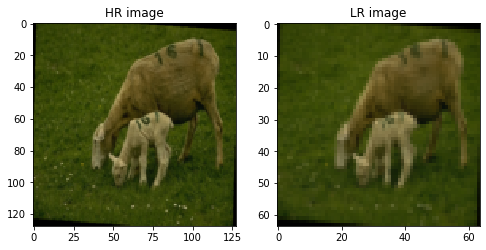

In [196]:
hr_image, lr_image= next(iter(trainloader))
fig, ax = plt.subplots(1,2,figsize=(8,4))
print(hr_image.shape, lr_image.shape)
s=ax[0].imshow(np.transpose(np.asarray(hr_image[0]),(1,2,0)))
s=ax[0].set_title('HR image')
s=ax[1].imshow(np.transpose(np.asarray(lr_image[0]),(1,2,0)))
s=ax[1].set_title('LR image')


# SRCNN module

SRCNN consists of three layers


1.   A feature extraction layer with 

*   An upsampling layer with upSamplingFactor
*   kernel size of 9 and nBaseChannels channels, and preserves the image size and RELU


2.   A mapping layer with kernel size of 5  and nBaseChannels channels and preserves the image size and RELU
3. A reconstruction layer with kernel size of 3 without any activation

The weights are initialized to avoid the growth of coefficients, which will accelerate the training





In [197]:
class SRCNN(nn.Module):
    def __init__(self,nBaseChannels,upSamplingFactor) -> None:
      super(SRCNN, self).__init__()
      
      # Feature extraction layer.
      self.features = nn.Sequential(
        nn.Upsample(scale_factor=upSamplingFactor),  
        nn.Conv2d(3, nBaseChannels, 9,1,4),
        nn.ReLU(True)
      )

      # Non-linear mapping layer.
      self.map = nn.Sequential(
        nn.Conv2d(nBaseChannels, nBaseChannels, 5,1,2),
        nn.ReLU(True),
      )

      # Reconstruction layer.
      self.reconstruction = nn.Conv2d(nBaseChannels, 3, 5,1,2)

      # Initialize model weights.
      self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      out = self.features(x)
      out = self.map(out)
      out = self.reconstruction(out)
      return torch.clip(out,min=0,max=1)

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
      for module in self.modules():
          if isinstance(module, nn.Conv2d):
              torch.nn.init.xavier_uniform_(module.weight)
              #nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
              nn.init.zeros_(module.bias.data)

      nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
      nn.init.zeros_(self.reconstruction.bias.data)

# <font color=red> Task 1: SRResnet module </font>

You will construct a Resnet to improve the super-resolution performance. A resnet include several residual blocks. A residual block implements 

$$y(x) = x + {\rm RELU}(H*x),$$
where $H$ denotes a filterbank that preserves the channels and image size. 

Your <font color=red>**subtasks**</font> are the following

1.   Construct a residual block class with channels and kernel size as variables, and implements the above equation


2.   Construct a SRResnet class with a feature and reconstruction layer similar to SRCNN above. The intermediate mapping layer should be replaced by five residual blocks

3. The weights of the resnet need to be initialized using Xavier initialization

In [198]:
class ResidualBlock(nn.Module):
  def __init__(self, nBaseChannels):
    super(ResidualBlock,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=nBaseChannels,out_channels=nBaseChannels,kernel_size=3,stride=1,padding=1, bias=False)
    self.in1 = nn.InstanceNorm2d(nBaseChannels, affine=True)
    self.relu = nn.LeakyReLU(0.2, inplace=True)
    self.conv2 = nn.Conv2d(in_channels=nBaseChannels, out_channels=nBaseChannels, kernel_size=3, stride=1, padding=1, bias=False)
    self.in2 = nn.InstanceNorm2d(nBaseChannels, affine=True)
  
  def forward(self, x):
    input_data = x
    output = self.relu(self.in1(self.conv1(x)))
    #print(input_data.shape)
    output = self.in2(self.conv2(output))
    output = torch.add(output, input_data)
    #print(output.shape)
    return output
    

In [199]:
#Code for testing the the Residual Block functionality

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
#net = ResidualBlock(32)
#print(sum([p.numel() for p in net.parameters()]))
#net.to(device)

#data = torch.rand((10,32,96,96))
#data = data.to(device)
#out = net(data)

In [200]:
class SRResnet(nn.Module):
    def __init__(self,nBaseChannels,upSamplingFactor) -> None:
      super(SRResnet, self).__init__()
      
      # Feature extraction layer.
      self.features = nn.Sequential(
        nn.Upsample(scale_factor=upSamplingFactor),  
        nn.Conv2d(3, nBaseChannels, 9,1,4),
        nn.ReLU(True)
      )

      # Non-linear mapping layer.
      self.map = nn.Sequential(
        nn.Conv2d(nBaseChannels, nBaseChannels, 5,1,2),
        nn.ReLU(True),
      )
      # Resnet blocks
      self.Resnet = nn.Sequential(
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels),
      ResidualBlock(nBaseChannels)
      )

      # Reconstruction layer.
      self.reconstruction = nn.Conv2d(nBaseChannels, 3, 5,1,2)

      # Initialize model weights.
      self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      out = self.features(x)
      #out = self.map(out)
      out = self.Resnet(out)
      out = self.reconstruction(out)
      return torch.clip(out,min=0,max=1)

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
      for module in self.modules():
          if isinstance(module, nn.Conv2d):
              torch.nn.init.xavier_uniform_(module.weight)
              #nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
              #nn.init.zeros_(module.bias.data)

      nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
      nn.init.zeros_(self.reconstruction.bias.data)

## <font color=red>Task 2: Replace SRCNN using SRResnet and train </font>

If task 1 is properly implemented, this step should be straight forward. Your <font color=red>**subtasks**</font> are the following



1.   Change the optimizers and the hyperparameters to see if you can improve performance of final testing error
2.  Experiment with weight decay and early stopping if you can improve performance 
3. Replace the l1 error loss used below with MSE and SSIM losses. Note that a variety of differentiable loss functions are available at https://piq.readthedocs.io/en/latest/. Feel free to experiment with them to improve image quality (optional)





In [201]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Net = SRCNN(32,upSamplingFactor=upSamplingFactor).to(device)
upSamplingFactor = 2
Net = SRResnet(32,upSamplingFactor=upSamplingFactor).to(device)


#lossfn = torch.nn.L1Loss()
lossfn = torch.nn.MSELoss()
#lossfn = SSIMLoss()

optimizer = optim.Adam(Net.parameters(), lr=0.00001)

for epoch in range(5):
  epochloss = 0
  for hr_image, lr_image in trainloader:
    out = Net(lr_image.to(device))
    cost =lossfn(out,hr_image.to(device))
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    epochloss += cost
  if np.mod(epoch,2)==0:
    print(epochloss.item()/dataset.__len__())

0.09102374076843261
0.04198748588562012
0.03070504665374756


## <font color=red>Task 3: Quantitative evaluation


Write a script to evaluate the above four different error metrics

In [207]:
L1= torch.nn.L1Loss()
MSE = torch.nn.MSELoss()
SSIM = SSIMLoss()
nll_loss = nn.NLLLoss()

hr_image, lr_image, = dataset.__getitem__(18)
hr_image = hr_image.unsqueeze(0)

# Image size may not be divisible by upSamplingFactor; resizing the original image
imsize = list(hr_image.shape[-2:])
imsize[0] = upSamplingFactor*int(imsize[0]/upSamplingFactor)
imsize[1] = upSamplingFactor*int(imsize[1]/upSamplingFactor)

Crop = T.CenterCrop(imsize)
hr_image = Crop(hr_image)
sx = int(imsize[0]/upSamplingFactor)
sy = int(imsize[1]/upSamplingFactor)
H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
lr_image = H2L(hr_image)
L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
bilinear = L2H(lr_image)
out = Net(lr_image.to(device)).detach().cpu()
sz = out.shape

# Generating the error matrics
print('comparison using error matrics')
print('L1 loss HR vs SuperRes: ',L1(out,hr_image[:,:,:sz[2],:sz[3]]).item())
print('L1 loss HR vs Bilinear: ',L1(bilinear,hr_image[:,:,:sz[2],:sz[3]]).item())
print('\n')
print('MSE loss HR vs SuperRes: ',MSE(out,hr_image[:,:,:sz[2],:sz[3]]).item())
print('MSE loss HR vs Bilinear: ',MSE(bilinear,hr_image[:,:,:sz[2],:sz[3]]).item())

comparison using error matrics
L1 loss HR vs SuperRes:  0.2570386826992035
L1 loss HR vs Bilinear:  0.02456883154809475


MSE loss HR vs SuperRes:  0.0817471370100975
MSE loss HR vs Bilinear:  0.0024874263908714056


# Visual evaluation on test data

Compare the image quality for the four different error metrics

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


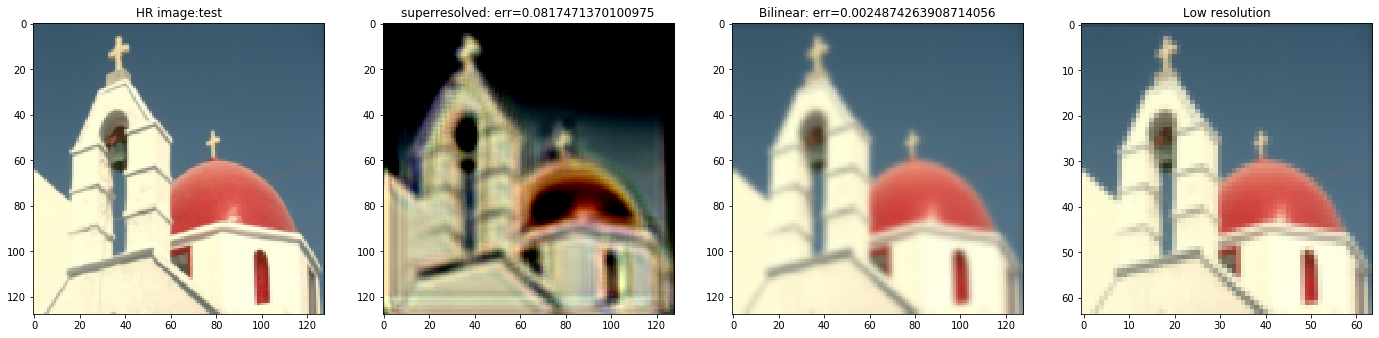

In [209]:

hr_image, lr_image = dataset.__getitem__(18)
hr_image = hr_image.unsqueeze(0)

# Image size may not be divisible by upSamplingFactor; resizing the original image
imsize = list(hr_image.shape[-2:])
imsize[0] = upSamplingFactor*int(imsize[0]/upSamplingFactor)
imsize[1] = upSamplingFactor*int(imsize[1]/upSamplingFactor)

Crop = T.CenterCrop(imsize)
hr_image = Crop(hr_image)
sx = int(imsize[0]/upSamplingFactor)
sy = int(imsize[1]/upSamplingFactor)
H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
lr_image = H2L(hr_image)
L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
bilinear = L2H(lr_image)

# Evaluation

out = Net(lr_image.to(device)).detach().cpu()
fig, ax = plt.subplots(1,4,figsize=(24,8))
s=ax[0].imshow(np.transpose(np.asarray(hr_image[0]),(1,2,0)))
s=ax[0].set_title('HR image:test')
s=ax[1].imshow(np.transpose(np.asarray(out[0]),(1,2,0)))
sz = out.shape
cost = lossfn(out,hr_image[:,:,:sz[2],:sz[3]]).item()

img_size = out.shape
s=ax[1].set_title('superresolved: err='+str(cost))

s=ax[2].imshow(np.transpose(np.asarray(bilinear[0]),(1,2,0)))
cost = lossfn(bilinear,hr_image).item()

s=ax[2].set_title('Bilinear: err='+str(cost))

s=ax[3].imshow(np.transpose(np.asarray(lr_image[0]),(1,2,0)))
s=ax[3].set_title('Low resolution')


# Try on training data. 

If the approach works well on training data and poorly on test data, it indicates overfitting

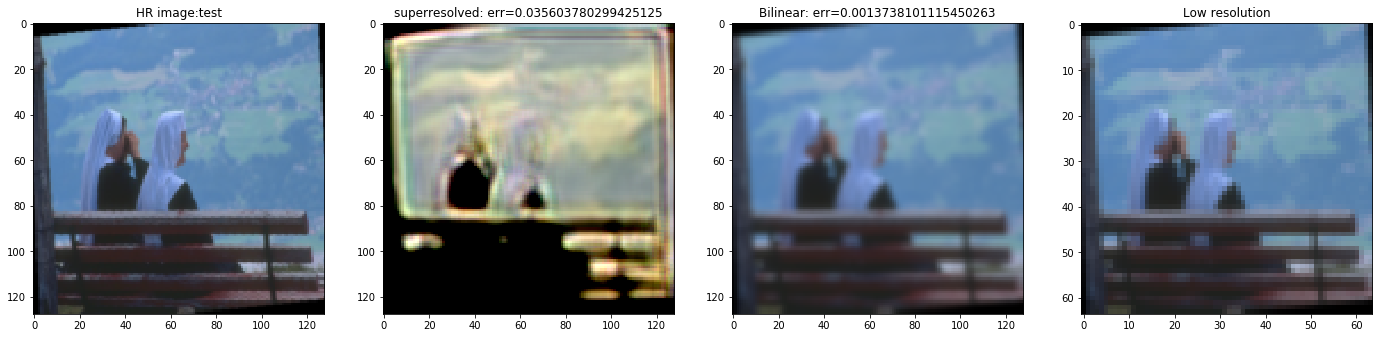

In [210]:
hr_image, lr_image= dataset.__getitem__(23)
hr_image = hr_image.unsqueeze(0)

imsize = list(hr_image.shape[-2:])

imsize[0] = upSamplingFactor*int(imsize[0]/upSamplingFactor)
imsize[1] = upSamplingFactor*int(imsize[1]/upSamplingFactor)

Crop = T.CenterCrop(imsize)
hr_image = Crop(hr_image)
sx = int(imsize[0]/upSamplingFactor)
sy = int(imsize[1]/upSamplingFactor)
H2L = T.Resize((sx,sy),interpolation=InterpolationMode.BILINEAR,antialias=True)
lr_image = H2L(hr_image)
L2H = T.Resize((imsize[0],imsize[1]),interpolation=InterpolationMode.BILINEAR)
bilinear = L2H(lr_image)

out = Net(lr_image.to(device)).detach().cpu()
fig, ax = plt.subplots(1,4,figsize=(24,8))
s=ax[0].imshow(np.transpose(np.asarray(hr_image[0]),(1,2,0)))
s=ax[0].set_title('HR image:test')
s=ax[1].imshow(np.transpose(np.asarray(out[0]),(1,2,0)))
sz = out.shape
cost = lossfn(out,hr_image[:,:,:sz[2],:sz[3]]).item()

img_size = out.shape
s=ax[1].set_title('superresolved: err='+str(cost))

s=ax[2].imshow(np.transpose(np.asarray(bilinear[0]),(1,2,0)))
cost = lossfn(bilinear,hr_image).item()

s=ax[2].set_title('Bilinear: err='+str(cost))

s=ax[3].imshow(np.transpose(np.asarray(lr_image[0]),(1,2,0)))
s=ax[3].set_title('Low resolution')

Error metrics

**SRResnet with SSIM loss**

L1 loss HR vs SuperRes:  0.023265749216079712

L1 loss HR vs Bilinear:  0.014107771217823029

MSE loss HR vs SuperRes:  0.001247800188139081

MSE loss HR vs Bilinear:  0.0007179907406680286

SSIM loss HR vs SuperRes:  0.0865442156791687

SSIM loss HR vs Bilinear:  0.10234689712524414

**SRResnet with MSE loss**

L1 loss HR vs SuperRes:  0.018103549256920815

L1 loss HR vs Bilinear:  0.014107771217823029

MSE loss HR vs SuperRes:  0.0007170972530730069

MSE loss HR vs Bilinear:  0.0007179907406680286


SSIM loss HR vs SuperRes:  0.07906270027160645

SSIM loss HR vs Bilinear:  0.10234689712524414

**SRResnet with L1 loss**

L1 loss HR vs SuperRes:  0.024259811267256737

L1 loss HR vs Bilinear:  0.014107771217823029


MSE loss HR vs SuperRes:  0.0013956906041130424

MSE loss HR vs Bilinear:  0.0007179907406680286


SSIM loss HR vs SuperRes:  0.10999870300292969

SSIM loss HR vs Bilinear:  0.10234689712524414
